In [9]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.display import display,clear_output,HTML
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore", DeprecationWarning)

import keras
from keras.layers import Dense,Dropout
from keras.models import Sequential

import researchpy as rp

%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',305)

from sklearn.feature_selection import SelectKBest,chi2,RFE,RFECV,f_regression,SelectFromModel,f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,cross_val_score

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn import metrics

from xgboost import XGBClassifier


from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,auc,roc_curve,recall_score,precision_score,matthews_corrcoef

from pandas_ml import ConfusionMatrix


from imblearn.over_sampling import SMOTE

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import featuretools as ft

from scipy import stats
import re

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [10]:
### Function to plot Feature Importance
def feat_impt_plot(feat_impt,y_labels,width_s=1000,height_s=1000):
    
    m=pd.DataFrame(y_labels,feat_impt).reset_index()
    m.columns=['Feature_Importance','Features']
    m.sort_values(by='Feature_Importance',inplace=True,ascending=False)
    m['Features']=m['Features'].str.replace("dom_function_","")
    m['Features']=m['Features'].str.replace("js_function_","")
    m['Features']=m['Features'].apply(lambda x: str(x).lstrip('.'))
    m['Features']=m['Features'].str.replace("(","")
    
    data = [go.Bar(x=m.Feature_Importance.values,y=m.Features.values,text=np.round(m.Feature_Importance,4),
            textposition = 'outside',
            marker=dict(
                color='rgb(158,202,225)',
                line=dict(
                    color='rgb(8,48,107)',
                    width=1.5),
            ),
            opacity=0.6,
            orientation='h'
        )]
    layout = go.Layout(autosize=False,
    width=width_s,
    height=height_s,
    xaxis=dict(title='Feature Importances',
        tickfont=dict(
            size=12,
            color='black'
        )),
    yaxis=dict(automargin=True))
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

In [11]:
def model_build(model,X_train,Y_train,X_test,Y_test,tree=False,feat=None):
    
    y_pred_train=model.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    
    print("Accuracy of the model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=model.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the model for test data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    mcc=matthews_corrcoef(Y_test,y_pred_test)
    
    precision=precision_score(Y_test,y_pred_test)
    recall=recall_score(Y_test,y_pred_test)
    if tree==True:
        feat_impt_plot(model.feature_importances_,feat)
        return model,cm_train,cm_test,acc_train,acc_test,roc_auc,model.feature_importances_,mcc,precision,recall
    
    return model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc,precision,recall

def KNN_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'K-Nearest Neighbors' + '\033[0m')
    knn=KNeighborsClassifier()
    knn.fit(X_train,Y_train)

    return model_build(knn,X_train,Y_train,X_test,Y_test)

# def Logistic_model(X_train,Y_train,X_test,Y_test):
#     print('\033[1m' + 'Logistic Regression' + '\033[0m')
#     log=LogisticRegression()
#     log.fit(X_train,Y_train)
    
#     return model_build(log,X_train,Y_train,X_test,Y_test)

def RandomForest(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'RandomForest Classifier' + '\033[0m')
    rf=RandomForestClassifier(random_state=0)
    rf.fit(X_train,Y_train)

    
    return model_build(rf,X_train,Y_train,X_test,Y_test,True,feat)

def AdaBoost(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'Adaoost Classifier' + '\033[0m')
    ada=AdaBoostClassifier(random_state=0)
    ada.fit(X_train,Y_train)
    
    return model_build(ada,X_train,Y_train,X_test,Y_test,True,feat)

def GradientBoosting(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'GradientBoosting Classifier' + '\033[0m')
    gbc=GradientBoostingClassifier(random_state=0)
    gbc.fit(X_train,Y_train)
    
    return model_build(gbc,X_train,Y_train,X_test,Y_test,True,feat)

def ExtraTree(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'ExtraTree Classifier' + '\033[0m')
    ext_tree=ExtraTreesClassifier(random_state=0)
    ext_tree.fit(X_train,Y_train)
    
    return model_build(ext_tree,X_train,Y_train,X_test,Y_test,True,feat)

def XGB(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'XGB Classifier' + '\033[0m')
    xgb=XGBClassifier(random_state=0)
    xgb.fit(X_train,Y_train)
    
    return model_build(xgb,X_train,Y_train,X_test,Y_test,True,feat)

def Bagging(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Bagging Classifier' + '\033[0m')
    bagging=BaggingClassifier(random_state=0)
    bagging.fit(X_train,Y_train)
    
    return model_build(bagging,X_train,Y_train,X_test,Y_test)

def XGB(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'XGB Classifier' + '\033[0m')
    xgb=XGBClassifier(random_state=0)
    xgb.fit(X_train,Y_train)
    
    return model_build(xgb,X_train,Y_train,X_test,Y_test,True,feat)

def DeepLearning1(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Neural Network-1' + '\033[0m')
    np.random.seed(0)
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=X_train.shape[1]))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)
    acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
    print("The accuracy of the model on training data is:",acc_train)
    cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
    cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
    display(cm_train)
    acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    print("The accuracy of the model on test data is:",acc_test)
    display(cm_test)
    mcc=matthews_corrcoef(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    precision=precision_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    recall=recall_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    return  deep_learning,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc,precision,recall

In [12]:
### Read HTML 
df_html=pd.read_csv('../html/HTML.csv',index_col='domain')
df_html.drop(['Unnamed: 0'],axis=1,inplace=True)
cookie=[col for col in df_html.columns if 'number' in col]
df_html.drop(cookie,axis=1,inplace=True)
print("Shape of HTML dataset:",df_html.shape)
df_html.Target=df_html.Target.apply(lambda x: 1 if x=='Malicious' else 0)


### Read JS 
df_js=pd.read_csv('Javascript.csv',low_memory=False,index_col='domain')
cookie=[col for col in df_js.columns if 'number' in col]
df_js.drop(cookie,axis=1,inplace=True)
df_js.rename(columns={'Malicious':'Target'},inplace=True)
print("Shape of JS,DOM dataset:",df_js.shape)
df_js.Target=df_js.Target.apply(lambda x: 1 if x=='Malicious' else 0)


### Read HTTP
df_http=pd.read_csv('HTTP.csv')
df_http.rename(columns={'Malicious':'Target'},inplace=True)
df_http.fillna(value=0,inplace=True)
cookies=[columns for columns in df_http.columns if 'number' in columns]
df_http.drop(cookies,axis=1,inplace=True)
df_http=df_http[df_http['domain']!=0]
df_http.sort_values(by='Target',inplace=True,ascending=False)
df_http.drop_duplicates(['domain'], keep='first',inplace=True)
df_http=df_http.sample(frac=1,random_state=0)
df_http.set_index(['domain'],drop=True,inplace=True)
print("Shape of HTTP dataset:",df_http.shape)



### Read URL
df_url=pd.read_csv('URL.csv')
df_url.fillna(value=0,inplace=True)
cookies=[columns for columns in df_url.columns if 'number' in columns]
df_url.drop(cookies,axis=1,inplace=True)
df_url.drop(['url_host','url_ip'],axis=1,inplace=True)
df_url=df_url[df_url['domain']!=0]
df_url.sort_values(by='Target',inplace=True,ascending=False)
df_url.drop_duplicates(['domain'], keep='first',inplace=True)
df_url=df_url.sample(frac=1,random_state=0)
print("Shape of URL dataset:",df_url.shape)
df_url.set_index('domain',inplace=True,drop=True)

Shape of HTML dataset: (43491, 1461)
Shape of JS,DOM dataset: (43294, 401)
Shape of HTTP dataset: (45856, 672)
Shape of URL dataset: (46771, 4194)


In [13]:
df=pd.concat([df_js,df_html,df_http,df_url],axis=1,join='inner')
df.drop(['Unnamed: 0'],axis=1,inplace=True)
df['Target_z']=df[['Target','Target','Target','Target']].apply(max,axis=1)
df.drop(['Target','Target','Target','Target'],axis=1,inplace=True)
print("Shape of combined dataset:",df.shape)
df.rename(columns={'Target_z':'Target'},inplace=True)
df.Target.value_counts()

Shape of combined dataset: (39183, 6723)


0    34742
1     4441
Name: Target, dtype: int64

In [46]:
columns=['js_function_.push(','a_count','a_href_http','a_href_https','a_href_out_of_domain','a_href_relative',
 'center_count','iframe_src_.html','img_src_http','input_count','li_count','link_href_out_of_domain','link_type_text/css',
 'meta_count','p_count','script_count','script_src_https','script_src_out_of_domain','title_count',
 'http_header_cache-control_set_max-age','http_header_content-encoding_gzip','http_header_content-length',
 'http_header_server_apache','http_header_transfer-encoding_chunked','http_header_vary_user-agent','http_header_via_1.1',
 'url_char_.','url_char_d','url_char_f','url_char_i','url_char_l','url_char_p','url_char_t','url_char_w',
 'url_char_y','url_char_z','url_extension_endswith_.com','url_extensions','url_length','Target']

print("features being used")
display(columns)

features being used


['js_function_.push(',
 'a_count',
 'a_href_http',
 'a_href_https',
 'a_href_out_of_domain',
 'a_href_relative',
 'center_count',
 'iframe_src_.html',
 'img_src_http',
 'input_count',
 'li_count',
 'link_href_out_of_domain',
 'link_type_text/css',
 'meta_count',
 'p_count',
 'script_count',
 'script_src_https',
 'script_src_out_of_domain',
 'title_count',
 'http_header_cache-control_set_max-age',
 'http_header_content-encoding_gzip',
 'http_header_content-length',
 'http_header_server_apache',
 'http_header_transfer-encoding_chunked',
 'http_header_vary_user-agent',
 'http_header_via_1.1',
 'url_char_.',
 'url_char_d',
 'url_char_f',
 'url_char_i',
 'url_char_l',
 'url_char_p',
 'url_char_t',
 'url_char_w',
 'url_char_y',
 'url_char_z',
 'url_extension_endswith_.com',
 'url_extensions',
 'url_length',
 'Target']

In [47]:
df['url_extension_endswith_.com']=df['url_extension_endswith_.com'].apply(lambda x: 1 if x==True else x)

In [48]:
df['url_extension_endswith_.com']=df['url_extension_endswith_.com'].astype(int)

### <a id='1' style="text-decoration : none; color : #000000;"> 1. Initial Models</a>

In [50]:
df_sel=df[columns].copy(deep=True)

train=df_sel.iloc[:27428,:]
train_X=train.iloc[:,train.columns!='Target'].values
train_Y=train.Target.values

scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(train_X)

test=df_sel.iloc[27428:,:]
test_X=test.iloc[:,test.columns!='Target'].values
test_Y=test.Target.values
scaled_X_test=scaler.transform(test_X)
columns.remove('Target')

In [17]:
ind_columns=['KNeighborsClassifier','RandomForestClassifier','AdaBoostClassifier',
             'GradientBoostingClassifier','ExtraTreeClassifier','XGB','BaggingClassifier','Neural Network-1']

f=[KNN_model,RandomForest,AdaBoost,GradientBoosting, ExtraTree,XGB,Bagging,DeepLearning1]

## Table to store training and test measures
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','MCC','Precision','Recall'])

feat_imp=[None]*5
j=0
for i in range(0,8):
    if i>=1 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc,prec,rec=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc,prec,rec=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y)
    table_80_50_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_50_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc,prec,rec])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.9803120898352049
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24167   160    24327
True         380  2721     3101
__all__    24547  2881    27428

Accuracy of the model for test data is: 0.974478945129732
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10319    96    10415
True         204  1136     1340
__all__    10523  1232    11755



RandomForest Classifier
Accuracy of the model for training data is: 0.9975572407758495
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24320     7    24327
True          60  3041     3101
__all__    24380  3048    27428

Accuracy of the model for test data is: 0.9786473840918758
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10359    56    10415
True         195  1145     1340
__all__    10554  1201    11755



Adaoost Classifier
Accuracy of the model for training data is: 0.9734577803704244
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24031   296    24327
True         432  2669     3101
__all__    24463  2965    27428

Accuracy of the model for test data is: 0.9716716290940025
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10279   136    10415
True         197  1143     1340
__all__    10476  1279    11755



GradientBoosting Classifier
Accuracy of the model for training data is: 0.9791089397695786
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24165   162    24327
True         411  2690     3101
__all__    24576  2852    27428

Accuracy of the model for test data is: 0.9751595065929392
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10333    82    10415
True         210  1130     1340
__all__    10543  1212    11755



ExtraTree Classifier
Accuracy of the model for training data is: 0.9994531136065334
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24325     2    24327
True          13  3088     3101
__all__    24338  3090    27428

Accuracy of the model for test data is: 0.9781369629944704
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10352    63    10415
True         194  1146     1340
__all__    10546  1209    11755



XGB Classifier
Accuracy of the model for training data is: 0.9794370716056584
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24183   144    24327
True         420  2681     3101
__all__    24603  2825    27428

Accuracy of the model for test data is: 0.9760102084219481
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10340    75    10415
True         207  1133     1340
__all__    10547  1208    11755



Bagging Classifier
Accuracy of the model for training data is: 0.9971926498468718
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24315    12    24327
True          65  3036     3101
__all__    24380  3048    27428

Accuracy of the model for test data is: 0.9780518928115696
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10337    78    10415
True         180  1160     1340
__all__    10517  1238    11755



Neural Network-1
The accuracy of the model on training data is: 0.995442613387779


Predicted  False  True  __all__
Actual                         
False      24289    38    24327
True          87  3014     3101
__all__    24376  3052    27428

The accuracy of the model on test data is: 0.9730327520204168


Predicted  False  True  __all__
Actual                         
False      10288   127    10415
True         190  1150     1340
__all__    10478  1277    11755

### <a id='1.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [18]:
trace0 = go.Scatter(x=table_80_50_test.iloc[0].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[0].values[[0,7,8,9,10]],
                    mode = 'lines',
                    name = 'KNN_model')


trace2 = go.Scatter(x=table_80_50_test.iloc[1].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[1].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_50_test.iloc[2].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[2].values[[0,7,8,9,10]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_50_test.iloc[3].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[3].values[[0,7,8,9,10]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_50_test.iloc[4].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[4].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')


trace1 = go.Scatter(x=table_80_50_test.iloc[5].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[5].values[[0,7,8,9,10]],
                    mode = 'lines+markers',
                    name = 'XGB')


trace6 = go.Scatter(x=table_80_50_test.iloc[6].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[6].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_50_test.iloc[7].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[7].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [19]:
table_80_50_train['index']=ind_columns
table_80_50_test['index']=ind_columns


table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_50_train)
print("Test Results")
display(table_80_50_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.980312,2721.0,24167.0,160.0,380.0,0.006577,0.122541
RandomForestClassifier,0.997557,3041.0,24320.0,7.0,60.0,0.000288,0.019349
AdaBoostClassifier,0.973458,2669.0,24031.0,296.0,432.0,0.012168,0.139310
GradientBoostingClassifier,0.979109,2690.0,24165.0,162.0,411.0,0.006659,0.132538
ExtraTreeClassifier,0.999453,3088.0,24325.0,2.0,13.0,0.000082,0.004192
XGB,0.979437,2681.0,24183.0,144.0,420.0,0.005919,0.135440
BaggingClassifier,0.997193,3036.0,24315.0,12.0,65.0,0.000493,0.020961
Neural Network-1,0.995443,3014.0,24289.0,38.0,87.0,0.001562,0.028055


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,MCC,Precision,Recall
index,,,,,,,,,,,
KNeighborsClassifier,0.974479,1136.0,10319.0,96.0,204.0,0.009217,0.152239,0.919272,0.870027,0.922078,0.847761
RandomForestClassifier,0.978647,1145.0,10359.0,56.0,195.0,0.005377,0.145522,0.924550,0.890966,0.953372,0.854478
AdaBoostClassifier,0.971672,1143.0,10279.0,136.0,197.0,0.013058,0.147015,0.919963,0.857217,0.893667,0.852985
GradientBoostingClassifier,0.975160,1130.0,10333.0,82.0,210.0,0.007873,0.156716,0.917705,0.873069,0.932343,0.843284
ExtraTreeClassifier,0.978137,1146.0,10352.0,63.0,194.0,0.006049,0.144776,0.924587,0.888428,0.947891,0.855224
XGB,0.976010,1133.0,10340.0,75.0,207.0,0.007201,0.154478,0.919161,0.877394,0.937914,0.845522
BaggingClassifier,0.978052,1160.0,10337.0,78.0,180.0,0.007489,0.134328,0.929091,0.888496,0.936995,0.865672
Neural Network-1,0.973033,1150.0,10288.0,127.0,190.0,0.012194,0.141791,0.929091,0.864023,0.900548,0.858209


### <a id='1.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [20]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='2' style="text-decoration : none; color : #000000;"> 2. OverSampling </a>

In [22]:
sm = SMOTE(random_state=12, ratio = {1:24327})
X_train, Y_train = sm.fit_sample(scaled_X_train,train_Y)


ind_columns=['KNeighborsClassifier','RandomForestClassifier','AdaBoostClassifier',
             'GradientBoostingClassifier','ExtraTreeClassifier','XGB','BaggingClassifier','Neural Network-1']

f=[KNN_model,RandomForest,AdaBoost,GradientBoosting, ExtraTree,XGB,Bagging,DeepLearning1]

## Table to store training and test measures
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','MCC','Precision','Recall'])

feat_imp=[None]*5
j=0
for i in range(0,8):
    if i>=1 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc,prec,rec=f[i](X_train,Y_train,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc,prec,rec=f[i](X_train,Y_train,scaled_X_test,test_Y)
    table_80_50_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_50_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc,prec,rec])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.9801249640317343
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      23392    935    24327
True          32  24295    24327
__all__    23424  25230    48654

Accuracy of the model for test data is: 0.9441088898341131
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9885   530    10415
True         127  1213     1340
__all__    10012  1743    11755



RandomForest Classifier
Accuracy of the model for training data is: 0.9990134418547293
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      24316     11    24327
True          37  24290    24327
__all__    24353  24301    48654

Accuracy of the model for test data is: 0.9775414717141642
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10326    89    10415
True         175  1165     1340
__all__    10501  1254    11755



Adaoost Classifier
Accuracy of the model for training data is: 0.9647716528959592
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      23410    917    24327
True         797  23530    24327
__all__    24207  24447    48654

Accuracy of the model for test data is: 0.9566992769034454
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10036   379    10415
True         130  1210     1340
__all__    10166  1589    11755



GradientBoosting Classifier
Accuracy of the model for training data is: 0.9770625231224566
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      23767    560    24327
True         556  23771    24327
__all__    24323  24331    48654

Accuracy of the model for test data is: 0.9658868566567418
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10156   259    10415
True         142  1198     1340
__all__    10298  1457    11755



ExtraTree Classifier
Accuracy of the model for training data is: 0.9996917005796029
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      24325      2    24327
True          13  24314    24327
__all__    24338  24316    48654

Accuracy of the model for test data is: 0.9776265418970651
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10339    76    10415
True         187  1153     1340
__all__    10526  1229    11755



XGB Classifier
Accuracy of the model for training data is: 0.976240391334731
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      23764    563    24327
True         593  23734    24327
__all__    24357  24297    48654

Accuracy of the model for test data is: 0.9655465759251383
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10148   267    10415
True         138  1202     1340
__all__    10286  1469    11755



Bagging Classifier
Accuracy of the model for training data is: 0.9987873556131048
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      24312     15    24327
True          44  24283    24327
__all__    24356  24298    48654

Accuracy of the model for test data is: 0.976095278604849
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10310   105    10415
True         176  1164     1340
__all__    10486  1269    11755



Neural Network-1
The accuracy of the model on training data is: 0.9953344021046574


Predicted  False   True  __all__
Actual                          
False      24258     69    24327
True         158  24169    24327
__all__    24416  24238    48654

The accuracy of the model on test data is: 0.9722671203743088


Predicted  False  True  __all__
Actual                         
False      10271   144    10415
True         182  1158     1340
__all__    10453  1302    11755

### <a id='2.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [23]:
trace0 = go.Scatter(x=table_80_50_test.iloc[0].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[0].values[[0,7,8,9,10]],
                    mode = 'lines',
                    name = 'KNN_model')


trace2 = go.Scatter(x=table_80_50_test.iloc[1].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[1].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_50_test.iloc[2].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[2].values[[0,7,8,9,10]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_50_test.iloc[3].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[3].values[[0,7,8,9,10]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_50_test.iloc[4].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[4].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')


trace1 = go.Scatter(x=table_80_50_test.iloc[5].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[5].values[[0,7,8,9,10]],
                    mode = 'lines+markers',
                    name = 'XGB')


trace6 = go.Scatter(x=table_80_50_test.iloc[6].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[6].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_50_test.iloc[7].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[7].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [24]:
### 14164
table_80_50_train['index']=ind_columns
table_80_50_test['index']=ind_columns


table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_50_train)
print("Test Results")
display(table_80_50_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.980125,24295.0,23392.0,935.0,32.0,0.038435,0.001315
RandomForestClassifier,0.999013,24290.0,24316.0,11.0,37.0,0.000452,0.001521
AdaBoostClassifier,0.964772,23530.0,23410.0,917.0,797.0,0.037695,0.032762
GradientBoostingClassifier,0.977063,23771.0,23767.0,560.0,556.0,0.023020,0.022855
ExtraTreeClassifier,0.999692,24314.0,24325.0,2.0,13.0,0.000082,0.000534
XGB,0.976240,23734.0,23764.0,563.0,593.0,0.023143,0.024376
BaggingClassifier,0.998787,24283.0,24312.0,15.0,44.0,0.000617,0.001809
Neural Network-1,0.995334,24169.0,24258.0,69.0,158.0,0.002836,0.006495


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,MCC,Precision,Recall
index,,,,,,,,,,,
KNeighborsClassifier,0.944109,1213.0,9885.0,530.0,127.0,0.050888,0.094776,0.927168,0.764014,0.695927,0.905224
RandomForestClassifier,0.977541,1165.0,10326.0,89.0,175.0,0.008545,0.130597,0.930429,0.886236,0.929027,0.869403
AdaBoostClassifier,0.956699,1210.0,10036.0,379.0,130.0,0.036390,0.097015,0.933298,0.805492,0.761485,0.902985
GradientBoostingClassifier,0.965887,1198.0,10156.0,259.0,142.0,0.024868,0.105970,0.934581,0.838256,0.822237,0.894030
ExtraTreeClassifier,0.977627,1153.0,10339.0,76.0,187.0,0.007297,0.139552,0.926575,0.886135,0.938161,0.860448
XGB,0.965547,1202.0,10148.0,267.0,138.0,0.025636,0.102985,0.935689,0.837442,0.818244,0.897015
BaggingClassifier,0.976095,1164.0,10310.0,105.0,176.0,0.010082,0.131343,0.929288,0.879275,0.917258,0.868657
Neural Network-1,0.972267,1158.0,10271.0,144.0,182.0,0.013826,0.135821,0.929288,0.861103,0.889401,0.864179


### <a id='2.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [25]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='3' style="text-decoration : none; color : #000000;">3. UnderSampling </a>

In [26]:
df_non=train[train.Target==0]
df_mal=train[train.Target==1]

df_non=df_non.sample(frac=len(df_mal)/len(df_non),random_state=0)
df_u=df_non.append(df_mal)
df_u.Target.value_counts() 

X_train=df_u[columns]
X_train=scaler.transform(X_train)
Y_train=df_u.Target.values

print("Shape after undersampling",X_train.shape)

## Table to store training and test measures so we can compare later
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','MCC','Precision','Recall'])

feat_imp=[None]*5
j=0
for i in range(0,8):
    if i>=1 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc,prec,rec=f[i](X_train,Y_train,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc,prec,rec=f[i](X_train,Y_train,scaled_X_test,test_Y)
    table_80_50_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_50_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc,prec,rec])
    print("\n")

Shape after undersampling (6202, 39)
K-Nearest Neighbors
Accuracy of the model for training data is: 0.9521122218639149
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       2964   137     3101
True         160  2941     3101
__all__     3124  3078     6202

Accuracy of the model for test data is: 0.935431731178222
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9760   655    10415
True         104  1236     1340
__all__     9864  1891    11755



RandomForest Classifier
Accuracy of the model for training data is: 0.9970977104159948
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3096     5     3101
True          13  3088     3101
__all__     3109  3093     6202

Accuracy of the model for test data is: 0.9584006805614632
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10025   390    10415
True          99  1241     1340
__all__    10124  1631    11755



Adaoost Classifier
Accuracy of the model for training data is: 0.9377620122541116
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       2886   215     3101
True         171  2930     3101
__all__     3057  3145     6202

Accuracy of the model for test data is: 0.9344959591663122
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9736   679    10415
True          91  1249     1340
__all__     9827  1928    11755



GradientBoosting Classifier
Accuracy of the model for training data is: 0.9574330861012577
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       2975   126     3101
True         138  2963     3101
__all__     3113  3089     6202

Accuracy of the model for test data is: 0.9515099957464909
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9933   482    10415
True          88  1252     1340
__all__    10021  1734    11755



ExtraTree Classifier
Accuracy of the model for training data is: 0.9995162850693324
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3101     0     3101
True           3  3098     3101
__all__     3104  3098     6202

Accuracy of the model for test data is: 0.9596767333049766
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10041   374    10415
True         100  1240     1340
__all__    10141  1614    11755



XGB Classifier
Accuracy of the model for training data is: 0.9551757497581426
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       2973   128     3101
True         150  2951     3101
__all__     3123  3079     6202

Accuracy of the model for test data is: 0.9526159081242025
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9949   466    10415
True          91  1249     1340
__all__    10040  1715    11755



Bagging Classifier
Accuracy of the model for training data is: 0.9958078039342148
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3094     7     3101
True          19  3082     3101
__all__     3113  3089     6202

Accuracy of the model for test data is: 0.9538919608677159
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9983   432    10415
True         110  1230     1340
__all__    10093  1662    11755



Neural Network-1
The accuracy of the model on training data is: 0.9912931312479846


Predicted  False  True  __all__
Actual                         
False       3096     5     3101
True          49  3052     3101
__all__     3145  3057     6202

The accuracy of the model on test data is: 0.945044661846023


Predicted  False  True  __all__
Actual                         
False       9878   537    10415
True         109  1231     1340
__all__     9987  1768    11755

### <a id='3.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [27]:
trace0 = go.Scatter(x=table_80_50_test.iloc[0].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[0].values[[0,7,8,9,10]],
                    mode = 'lines',
                    name = 'KNN_model')


trace2 = go.Scatter(x=table_80_50_test.iloc[1].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[1].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_50_test.iloc[2].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[2].values[[0,7,8,9,10]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_50_test.iloc[3].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[3].values[[0,7,8,9,10]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_50_test.iloc[4].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[4].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')


trace1 = go.Scatter(x=table_80_50_test.iloc[5].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[5].values[[0,7,8,9,10]],
                    mode = 'lines+markers',
                    name = 'XGB')


trace6 = go.Scatter(x=table_80_50_test.iloc[6].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[6].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_50_test.iloc[7].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[7].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [28]:
table_80_50_train['index']=ind_columns
table_80_50_test['index']=ind_columns


table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_50_train)
print("Test Results")
display(table_80_50_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.952112,2941.0,2964.0,137.0,160.0,0.044179,0.051596
RandomForestClassifier,0.997098,3088.0,3096.0,5.0,13.0,0.001612,0.004192
AdaBoostClassifier,0.937762,2930.0,2886.0,215.0,171.0,0.069332,0.055144
GradientBoostingClassifier,0.957433,2963.0,2975.0,126.0,138.0,0.040632,0.044502
ExtraTreeClassifier,0.999516,3098.0,3101.0,0.0,3.0,0.000000,0.000967
XGB,0.955176,2951.0,2973.0,128.0,150.0,0.041277,0.048371
BaggingClassifier,0.995808,3082.0,3094.0,7.0,19.0,0.002257,0.006127
Neural Network-1,0.991293,3052.0,3096.0,5.0,49.0,0.001612,0.015801


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,MCC,Precision,Recall
index,,,,,,,,,,,
KNeighborsClassifier,0.935432,1236.0,9760.0,655.0,104.0,0.062890,0.077612,0.929749,0.743455,0.653622,0.922388
RandomForestClassifier,0.958401,1241.0,10025.0,390.0,99.0,0.037446,0.073881,0.944337,0.816998,0.760883,0.926119
AdaBoostClassifier,0.934496,1249.0,9736.0,679.0,91.0,0.065194,0.067910,0.933448,0.744020,0.647822,0.932090
GradientBoostingClassifier,0.951510,1252.0,9933.0,482.0,88.0,0.046279,0.065672,0.944024,0.795864,0.722030,0.934328
ExtraTreeClassifier,0.959677,1240.0,10041.0,374.0,100.0,0.035910,0.074627,0.944732,0.821331,0.768278,0.925373
XGB,0.952616,1249.0,9949.0,466.0,91.0,0.044743,0.067910,0.943673,0.798870,0.728280,0.932090
BaggingClassifier,0.953892,1230.0,9983.0,432.0,110.0,0.041479,0.082090,0.938216,0.799419,0.740072,0.917910
Neural Network-1,0.945045,1231.0,9878.0,537.0,109.0,0.051560,0.081343,0.938216,0.770887,0.696267,0.918657


### <a id='3.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [29]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='4' style="text-decoration : none; color : #000000;">4. Feature Transformation with feature selection </a>

In [52]:
df.reset_index(inplace=True)
columns.append('domain')
df_min=df[columns]

In [53]:
es = ft.EntitySet(id = 'malicious')
es.entity_from_dataframe(entity_id = 'data', dataframe = df_min, index = 'domain')

feature_matrix_sessions, features_defs = ft.dfs(entityset=es,target_entity="data",
                                                trans_primitives = ['add','divide','multiply'],n_jobs=-1,
                                                verbose=1,max_depth=1)

Built 3003 features
EntitySet scattered to workers in 4.893 seconds
Elapsed: 00:20 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/distributed/utils.py", line 713, in log_errors
    yield
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/distributed/client.py", line 1223, in _close
    quiet_exceptions=(CancelledError,),
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 584, in with_timeout
    chain_future(future_converted, result)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 166, in chain_future
    future_add_done_callback(a, copy)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 262, in future_add_done_callback
    callback(future)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 160, in copy
    elif a.ex

In [54]:
df.set_index(['domain'],drop=True,inplace=True)
fs=pd.merge(feature_matrix_sessions,pd.DataFrame(df_sel.Target),left_index=True, right_index=True)
fs.replace([np.inf],0,inplace=True)
fs.fillna(value=0,inplace=True)

X=fs.loc[:,fs.columns!='Target']
y=fs.Target
feature_name = X.columns.tolist()

distributed.core - INFO - Event loop was unresponsive in Nanny for 4.14s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.97s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.97s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.97s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 5.62s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 7.84s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 7.17s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 7.17s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 7.81s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 5.61s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 3.18s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.19s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.19s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.16s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.16s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 6.57s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.58s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 5.81s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 7.17s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 5.58s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.14s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 7.15s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 7.15s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

In [56]:
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-100:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature


cor_support, cor_feature = cor_selector(X, y)

In [57]:
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=100)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()

In [58]:
rfe_selector = RFE(estimator=LogisticRegression(random_state=0), n_features_to_select=100, step=0.3, verbose=False)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()

In [59]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100,random_state=0), threshold='23*median')
embeded_rf_selector.fit(X, y)
embeded_rf_support = embeded_rf_selector.get_support()

In [61]:
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()

In [63]:
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support,
                                    'Random Forest':embeded_rf_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)

In [64]:
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support,
                                    'Random Forest':embeded_rf_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)

In [65]:
X=fs[feature_selection_df[feature_selection_df.Total>=3]['Feature']]
X.fillna(value=0,inplace=True)
y=fs.Target.values
feature_name = X.columns.tolist()

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 70:30")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.3)

X.shape

The train/test split ratio is 70:30


(39183, 33)

In [66]:
print('Features we will be using:\n')
display(feature_name)

Features we will be using:



['url_char_w + url_char_z',
 'url_char_f + url_char_w',
 'url_char_. + url_char_z',
 'url_char_. + url_char_w',
 'url_char_. + url_char_f',
 'url_extensions + url_length',
 'url_char_z + url_extensions',
 'url_char_z * url_length',
 'url_char_y / url_char_z',
 'url_char_y * url_extensions',
 'url_char_w + url_length',
 'url_char_w + url_extensions',
 'url_char_w + url_char_y',
 'url_char_w * url_length',
 'url_char_w * url_extensions',
 'url_char_w',
 'url_char_p + url_extensions',
 'url_char_l + url_extensions',
 'url_char_l + url_char_w',
 'url_char_f + url_extensions',
 'url_char_. + url_char_y',
 'url_char_. * url_char_z',
 'url_char_. * url_char_w',
 'url_char_.',
 'http_header_vary_user-agent / url_char_z',
 'http_header_vary_user-agent / http_header_content-length',
 'http_header_vary_user-agent + url_char_.',
 'http_header_server_apache + url_char_w',
 'http_header_server_apache + url_char_.',
 'http_header_content-encoding_gzip / url_char_.',
 'http_header_content-encoding_gzi

In [68]:
fs.shape[0]*0.7

27428.1

In [69]:
fs=fs.reindex(df_sel.index.values)

train=fs.iloc[:27428]
train_Y=train.Target.values
train_X=train[feature_name].values


scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(train_X)

test=fs.iloc[27428:]
test_Y=test.Target.values
test_X=test[feature_name]

scaled_X_test=scaler.transform(test_X)

In [70]:
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','MCC','Precision','Recall'])

feat_imp=[None]*5
j=0
for i in range(0,8):
    if i>=1 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc,prec,rec=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y,feature_name)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc,prec,rec=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y)
    table_80_50_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_50_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc,prec,rec])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.978088085168441
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24143   184    24327
True         417  2684     3101
__all__    24560  2868    27428

Accuracy of the model for test data is: 0.9722671203743088
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10310   105    10415
True         221  1119     1340
__all__    10531  1224    11755



RandomForest Classifier
Accuracy of the model for training data is: 0.9919060813766953
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24274    53    24327
True         169  2932     3101
__all__    24443  2985    27428

Accuracy of the model for test data is: 0.973713313483624
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10327    88    10415
True         221  1119     1340
__all__    10548  1207    11755



Adaoost Classifier
Accuracy of the model for training data is: 0.9737859122065043
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24104   223    24327
True         496  2605     3101
__all__    24600  2828    27428

Accuracy of the model for test data is: 0.9703955763504891
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10301   114    10415
True         234  1106     1340
__all__    10535  1220    11755

distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/distributed/utils.py", line 713, in log_errors
    yield
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/distributed/client.py", line 1223, in _close
    quiet_exceptions=(CancelledError,),
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 584, in with_timeout
    chain_future(future_converted, result)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 166, in chain_future
    future_add_done_callback(a, copy)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 262, in future_add_done_callback
    callback(future)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 160, in copy
    elif a.exception() is not None:
concurrent.futures._base.CancelledError
Exception ignored in: <bound method



GradientBoosting Classifier
Accuracy of the model for training data is: 0.9778693306110544
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24145   182    24327
True         425  2676     3101
__all__    24570  2858    27428

Accuracy of the model for test data is: 0.9743938749468312
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10313   102    10415
True         199  1141     1340
__all__    10512  1243    11755



ExtraTree Classifier
Accuracy of the model for training data is: 0.9936561178357882
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24307    20    24327
True         154  2947     3101
__all__    24461  2967    27428

Accuracy of the model for test data is: 0.9728626116546151
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10320    95    10415
True         224  1116     1340
__all__    10544  1211    11755



XGB Classifier
Accuracy of the model for training data is: 0.9771766078459968
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24163   164    24327
True         462  2639     3101
__all__    24625  2803    27428

Accuracy of the model for test data is: 0.9749042960442365
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10329    86    10415
True         209  1131     1340
__all__    10538  1217    11755



Bagging Classifier
Accuracy of the model for training data is: 0.9914685722619221
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24269    58    24327
True         176  2925     3101
__all__    24445  2983    27428

Accuracy of the model for test data is: 0.9724372607401106
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10304   111    10415
True         213  1127     1340
__all__    10517  1238    11755



Neural Network-1
The accuracy of the model on training data is: 0.984869476447426


Predicted  False  True  __all__
Actual                         
False      24255    72    24327
True         343  2758     3101
__all__    24598  2830    27428

The accuracy of the model on test data is: 0.9727775414717141


Predicted  False  True  __all__
Actual                         
False      10326    89    10415
True         231  1109     1340
__all__    10557  1198    11755

### <a id='4.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [71]:
trace0 = go.Scatter(x=table_80_50_test.iloc[0].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[0].values[[0,7,8,9,10]],
                    mode = 'lines',
                    name = 'KNN_model')


trace2 = go.Scatter(x=table_80_50_test.iloc[1].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[1].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_50_test.iloc[2].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[2].values[[0,7,8,9,10]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_50_test.iloc[3].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[3].values[[0,7,8,9,10]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_50_test.iloc[4].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[4].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')


trace1 = go.Scatter(x=table_80_50_test.iloc[5].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[5].values[[0,7,8,9,10]],
                    mode = 'lines+markers',
                    name = 'XGB')


trace6 = go.Scatter(x=table_80_50_test.iloc[6].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[6].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_50_test.iloc[7].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[7].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [72]:
table_80_50_train['index']=ind_columns
table_80_50_test['index']=ind_columns


table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_50_train)
print("Test Results")
display(table_80_50_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.978088,2684.0,24143.0,184.0,417.0,0.007564,0.134473
RandomForestClassifier,0.991906,2932.0,24274.0,53.0,169.0,0.002179,0.054499
AdaBoostClassifier,0.973786,2605.0,24104.0,223.0,496.0,0.009167,0.159948
GradientBoostingClassifier,0.977869,2676.0,24145.0,182.0,425.0,0.007481,0.137053
ExtraTreeClassifier,0.993656,2947.0,24307.0,20.0,154.0,0.000822,0.049661
XGB,0.977177,2639.0,24163.0,164.0,462.0,0.006741,0.148984
BaggingClassifier,0.991469,2925.0,24269.0,58.0,176.0,0.002384,0.056756
Neural Network-1,0.984869,2758.0,24255.0,72.0,343.0,0.002960,0.110609


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,MCC,Precision,Recall
index,,,,,,,,,,,
KNeighborsClassifier,0.972267,1119.0,10310.0,105.0,221.0,0.010082,0.164925,0.912497,0.858434,0.914216,0.835075
RandomForestClassifier,0.973713,1119.0,10327.0,88.0,221.0,0.008449,0.164925,0.913313,0.865470,0.927092,0.835075
AdaBoostClassifier,0.970396,1106.0,10301.0,114.0,234.0,0.010946,0.174627,0.907214,0.848667,0.906557,0.825373
GradientBoostingClassifier,0.974394,1141.0,10313.0,102.0,199.0,0.009794,0.148507,0.920849,0.869882,0.917940,0.851493
ExtraTreeClassifier,0.972863,1116.0,10320.0,95.0,224.0,0.009121,0.167164,0.911857,0.861160,0.921552,0.832836
XGB,0.974904,1131.0,10329.0,86.0,209.0,0.008257,0.155970,0.917886,0.871858,0.929334,0.844030
BaggingClassifier,0.972437,1127.0,10304.0,111.0,213.0,0.010658,0.158955,0.915194,0.859719,0.910339,0.841045
Neural Network-1,0.972778,1109.0,10326.0,89.0,231.0,0.008545,0.172388,0.915194,0.860404,0.925710,0.827612


### <a id='4.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [74]:
feat_impt_plot(np.average(feat_imp,axis=0),feature_name)

### <a id='5' style="text-decoration : none; color : #000000;">5. Feature Transformation with PCA </a>

distributed.core - INFO - Event loop was unresponsive in Nanny for 158.21s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 158.21s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 158.21s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 158.21s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 158.22s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

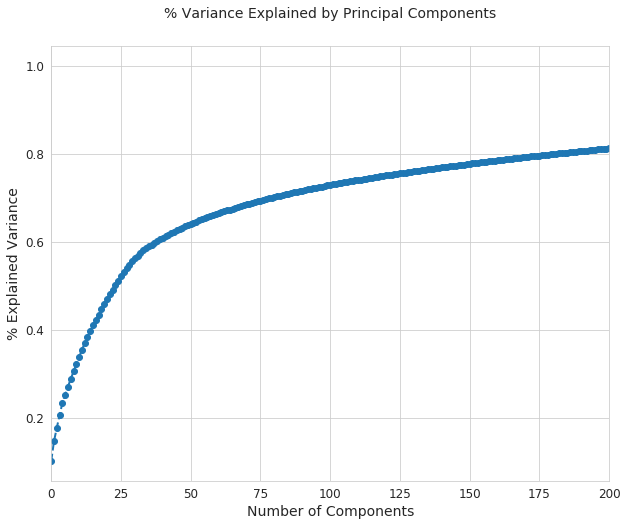

In [75]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target.values
feature_name = X.columns.tolist()
X=np.nan_to_num(X)
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

sns.set_style('whitegrid')
pca = PCA(random_state=0)
pca.fit(scaled_X)
plt.figure(1, figsize=(10, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_),'--o', linewidth=2)
plt.axis('tight')
plt.xlabel('Number of Components',size=14)
plt.xticks(size=12)
plt.xlim([0,200])
plt.ylabel('% Explained Variance',size=14)
plt.yticks(size=12)
plt.title('% Variance Explained by Principal Components',size=14,y=1.05)
plt.show()

In [76]:
pca=PCA(n_components=175,whiten=True,random_state=0)
X_pca_21=pca.fit_transform(scaled_X)
print("Variance explained using 175 components is:",sum(pca.explained_variance_ratio_))

Variance explained using 175 components is: 0.7944361842977952


In [77]:
X_train=X_pca_21[:27428]
Y_train=fs.iloc[:27428]['Target'].values
X_test=X_pca_21[27428:]
Y_test=fs.iloc[27428:]['Target'].values

## Table to store training and test measures so we can compare later
table_80_70_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [84]:
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','MCC','Precision','Recall'])

feat_imp=[None]*5
j=0
for i in range(0,8):
    if i>=1 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc,prec,rec=f[i](X_train,Y_train,X_test,Y_test,np.arange(0,175).astype(str))
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc,prec,rec=f[i](X_train,Y_train,X_test,Y_test)
    table_80_50_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_50_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc,prec,rec])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.9802027125565116
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24222   105    24327
True         438  2663     3101
__all__    24660  2768    27428

Accuracy of the model for test data is: 0.9721820501914079
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10348    67    10415
True         260  1080     1340
__all__    10608  1147    11755



RandomForest Classifier
Accuracy of the model for training data is: 0.996208254338632
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24321     6    24327
True          98  3003     3101
__all__    24419  3009    27428

Accuracy of the model for test data is: 0.971246278179498
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10351    64    10415
True         274  1066     1340
__all__    10625  1130    11755



Adaoost Classifier
Accuracy of the model for training data is: 0.9725098439550824
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24051   276    24327
True         478  2623     3101
__all__    24529  2899    27428

Accuracy of the model for test data is: 0.9672479795831561
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10256   159    10415
True         226  1114     1340
__all__    10482  1273    11755



GradientBoosting Classifier
Accuracy of the model for training data is: 0.9804214671138982
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24188   139    24327
True         398  2703     3101
__all__    24586  2842    27428

Accuracy of the model for test data is: 0.9726074011059124
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10323    92    10415
True         230  1110     1340
__all__    10553  1202    11755



ExtraTree Classifier
Accuracy of the model for training data is: 0.9994531136065334
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24325     2    24327
True          13  3088     3101
__all__    24338  3090    27428

Accuracy of the model for test data is: 0.968098681412165
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10368    47    10415
True         328  1012     1340
__all__    10696  1059    11755



XGB Classifier
Accuracy of the model for training data is: 0.9806402216712848
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24204   123    24327
True         408  2693     3101
__all__    24612  2816    27428

Accuracy of the model for test data is: 0.973713313483624
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10330    85    10415
True         224  1116     1340
__all__    10554  1201    11755



Bagging Classifier
Accuracy of the model for training data is: 0.9969738952894852
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24319     8    24327
True          75  3026     3101
__all__    24394  3034    27428

Accuracy of the model for test data is: 0.9732028923862186
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10314   101    10415
True         214  1126     1340
__all__    10528  1227    11755



Neural Network-1
The accuracy of the model on training data is: 0.9979218317048272


Predicted  False  True  __all__
Actual                         
False      24313    14    24327
True          43  3058     3101
__all__    24356  3072    27428

The accuracy of the model on test data is: 0.974478945129732


Predicted  False  True  __all__
Actual                         
False      10295   120    10415
True         180  1160     1340
__all__    10475  1280    11755

### <a id='5.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [85]:
trace0 = go.Scatter(x=table_80_50_test.iloc[0].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[0].values[[0,7,8,9,10]],
                    mode = 'lines',
                    name = 'KNN_model')


trace2 = go.Scatter(x=table_80_50_test.iloc[1].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[1].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_50_test.iloc[2].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[2].values[[0,7,8,9,10]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_50_test.iloc[3].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[3].values[[0,7,8,9,10]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_50_test.iloc[4].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[4].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')


trace1 = go.Scatter(x=table_80_50_test.iloc[5].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[5].values[[0,7,8,9,10]],
                    mode = 'lines+markers',
                    name = 'XGB')


trace6 = go.Scatter(x=table_80_50_test.iloc[6].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[6].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_50_test.iloc[7].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[7].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [86]:
table_80_50_train['index']=ind_columns
table_80_50_test['index']=ind_columns


table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_50_train)
print("Test Results")
display(table_80_50_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.980203,2663.0,24222.0,105.0,438.0,0.004316,0.141245
RandomForestClassifier,0.996208,3003.0,24321.0,6.0,98.0,0.000247,0.031603
AdaBoostClassifier,0.972510,2623.0,24051.0,276.0,478.0,0.011345,0.154144
GradientBoostingClassifier,0.980421,2703.0,24188.0,139.0,398.0,0.005714,0.128346
ExtraTreeClassifier,0.999453,3088.0,24325.0,2.0,13.0,0.000082,0.004192
XGB,0.980640,2693.0,24204.0,123.0,408.0,0.005056,0.131570
BaggingClassifier,0.996974,3026.0,24319.0,8.0,75.0,0.000329,0.024186
Neural Network-1,0.997922,3058.0,24313.0,14.0,43.0,0.000575,0.013866


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,MCC,Precision,Recall
index,,,,,,,,,,,
KNeighborsClassifier,0.972182,1080.0,10348.0,67.0,260.0,0.006433,0.194030,0.899769,0.856293,0.941587,0.805970
RandomForestClassifier,0.971246,1066.0,10351.0,64.0,274.0,0.006145,0.204478,0.894689,0.851066,0.943363,0.795522
AdaBoostClassifier,0.967248,1114.0,10256.0,159.0,226.0,0.015266,0.168657,0.908038,0.834597,0.875098,0.831343
GradientBoostingClassifier,0.972607,1110.0,10323.0,92.0,230.0,0.008833,0.171642,0.909762,0.859615,0.923461,0.828358
ExtraTreeClassifier,0.968099,1012.0,10368.0,47.0,328.0,0.004513,0.244776,0.875356,0.833290,0.955619,0.755224
XGB,0.973713,1116.0,10330.0,85.0,224.0,0.008161,0.167164,0.912337,0.865336,0.929226,0.832836
BaggingClassifier,0.973203,1126.0,10314.0,101.0,214.0,0.009698,0.159701,0.915300,0.863335,0.917685,0.840299
Neural Network-1,0.974479,1160.0,10295.0,120.0,180.0,0.011522,0.134328,0.915300,0.871433,0.906250,0.865672


In [87]:
### Original Creator : Darshan Bhansali
### HTML code to hide the input cells 
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle code, click <a href="javascript:code_toggle()">here</a>.''')